In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.error_functions import *
from src.visualization import *
from src.evaluation import *
from src.data_augmentations import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

Using TensorFlow backend.


# Load Data

In [4]:
EPOCHS = 50
BATCH_SIZE = 50
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 120
FEATURES_NUMBER = 3
OUTPUT_SIZE = HORIZON*3
LOSS = kl_divergance_diff
PI_PARAMS = {'max_coff': 1.0, 'min_coff': 0.3, 'step': 0.3}

stdAugmentation = StdAugmentation(PI_PARAMS)
diffAugmentation = DiffAugmentation()
x_augmentations = [diffAugmentation, stdAugmentation]
y_augmentations = [diffAugmentation, stdAugmentation]

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv", 
                           x_augmentations, 
                           y_augmentations,
                           LOOKBACK, HORIZON,  validation_ratio=0.05)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

print(train_y.shape)

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE, FEATURES_NUMBER)

(6472, 144)


In [3]:
from keras.callbacks.callbacks import Callback

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Train The Model

In [4]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')
callback1 = EarlyStoppingByLossVal(monitor='val_loss', value=0.5, verbose=1)

model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=0.001, loss = LOSS,
                dropout_ratio = 0.5, features_number = FEATURES_NUMBER, callbacks = [], pi_params=PI_PARAMS)

In [6]:
model = M4Model()
model.load( '../models/with_kl_pi_params_diff/3-LSTM/2')
model.compile()
model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Loaded model from disk
Epoch 1/50
129/129 [==============================] - 40s 306ms/step - loss: 0.2246 - val_loss: 0.2549
Epoch 2/50
129/129 [==============================] - 40s 314ms/step - loss: 0.2077 - val_loss: 0.2370
Epoch 3/50
129/129 [==============================] - 46s 359ms/step - loss: 0.2039 - val_loss: 0.2420
Epoch 4/50
129/129 [==============================] - 35s 274ms/step - loss: 0.2014 - val_loss: 0.2365
Epoch 5/50
129/129 [==============================] - 35s 274ms/step - loss: 0.2000 - val_loss: 0.2306
Epoch 6/50
129/129 [==============================] - 37s 285ms/step - loss: 0.1980 - val_loss: 0.2247
Epoch 7/50
129/129 [==============================] - 34s 266ms/step - loss: 0.1961 - val_loss: 0.2307
Epoch 8/50
129/129 [==============================] - 37s 289ms/step - loss: 0.1943 - val_loss: 0.2234
Epoch 9/50
129/129 [==============================] - 34s 265ms/step - loss: 0.1928 - val_loss: 0.2309
Epoch 10/50
129/129 [=============================

# Save The Model

In [8]:
MODEL_BASE_DIR = '../models/with_kl_pi_params_diff/3-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/with_kl_pi_params_diff/3-LSTM/3


# Get Best And Worst Predictions

Best Predection Error is     0.1784
Worst Predection Error is     9.5584


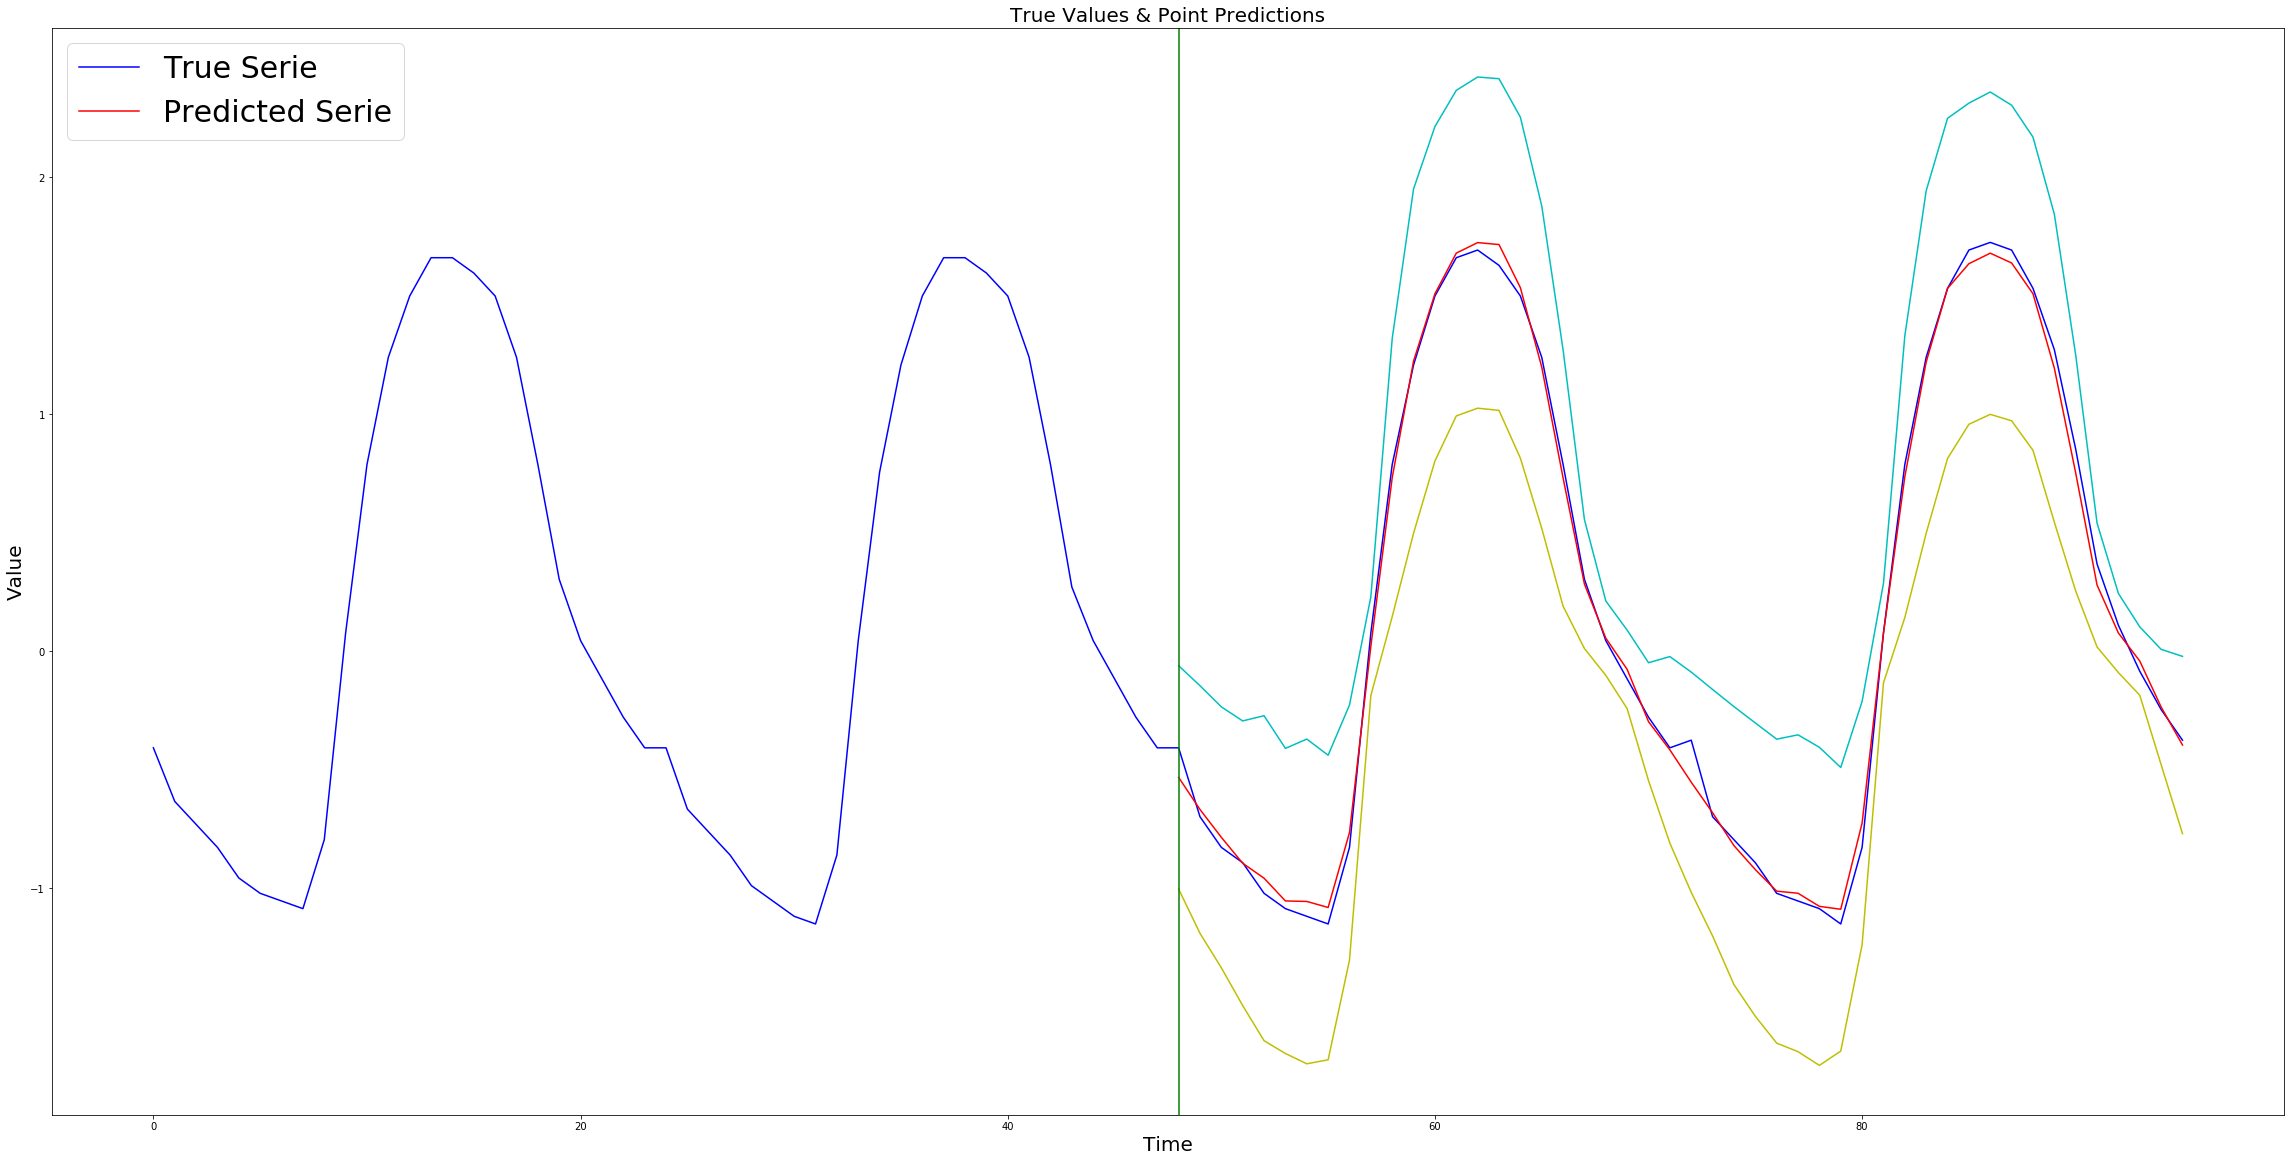

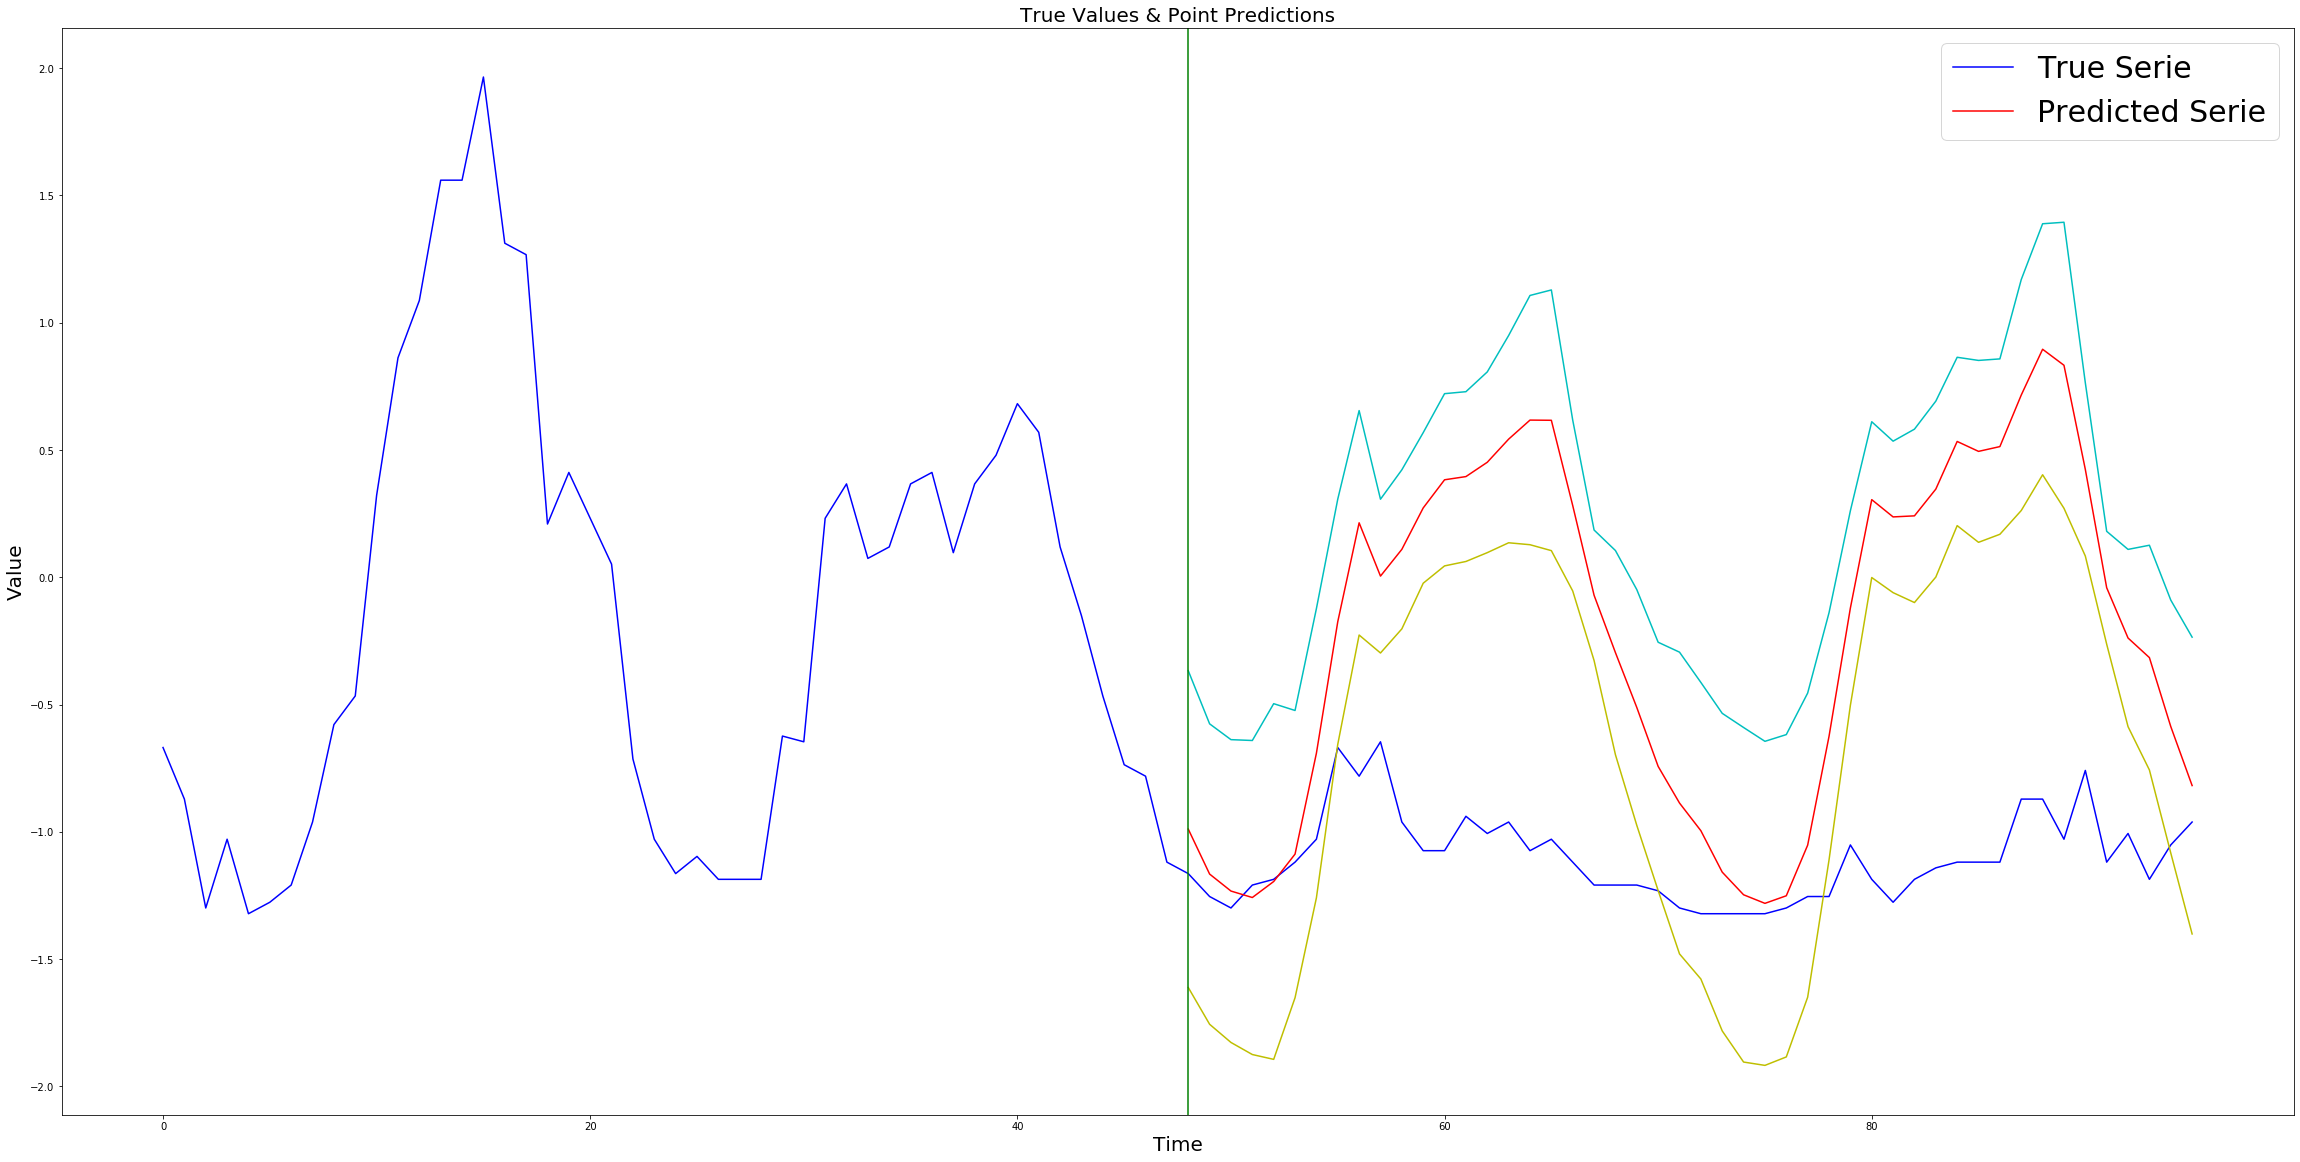

In [9]:
#model = M4Model()
#model.load('../models/with_kl_pi_params/3-LSTM/10')
#print(hp)

x, y, prediction, error =  sort_by_prediction_error(model,test_x, test_y, mase)

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[x.shape[0]-1]:10.4f}')

lower_bound = prediction[:,:48] - tf.abs(prediction[:,-48:])
upper_bound = prediction[:,:48] + tf.abs(prediction[:,-48:])
plot_serie_with_bounds(x[:,:LOOKBACK,0], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=0)
plot_serie_with_bounds(x[:,:LOOKBACK,0], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=x.shape[0]-1)

# PLot Specific Serie From A Batch

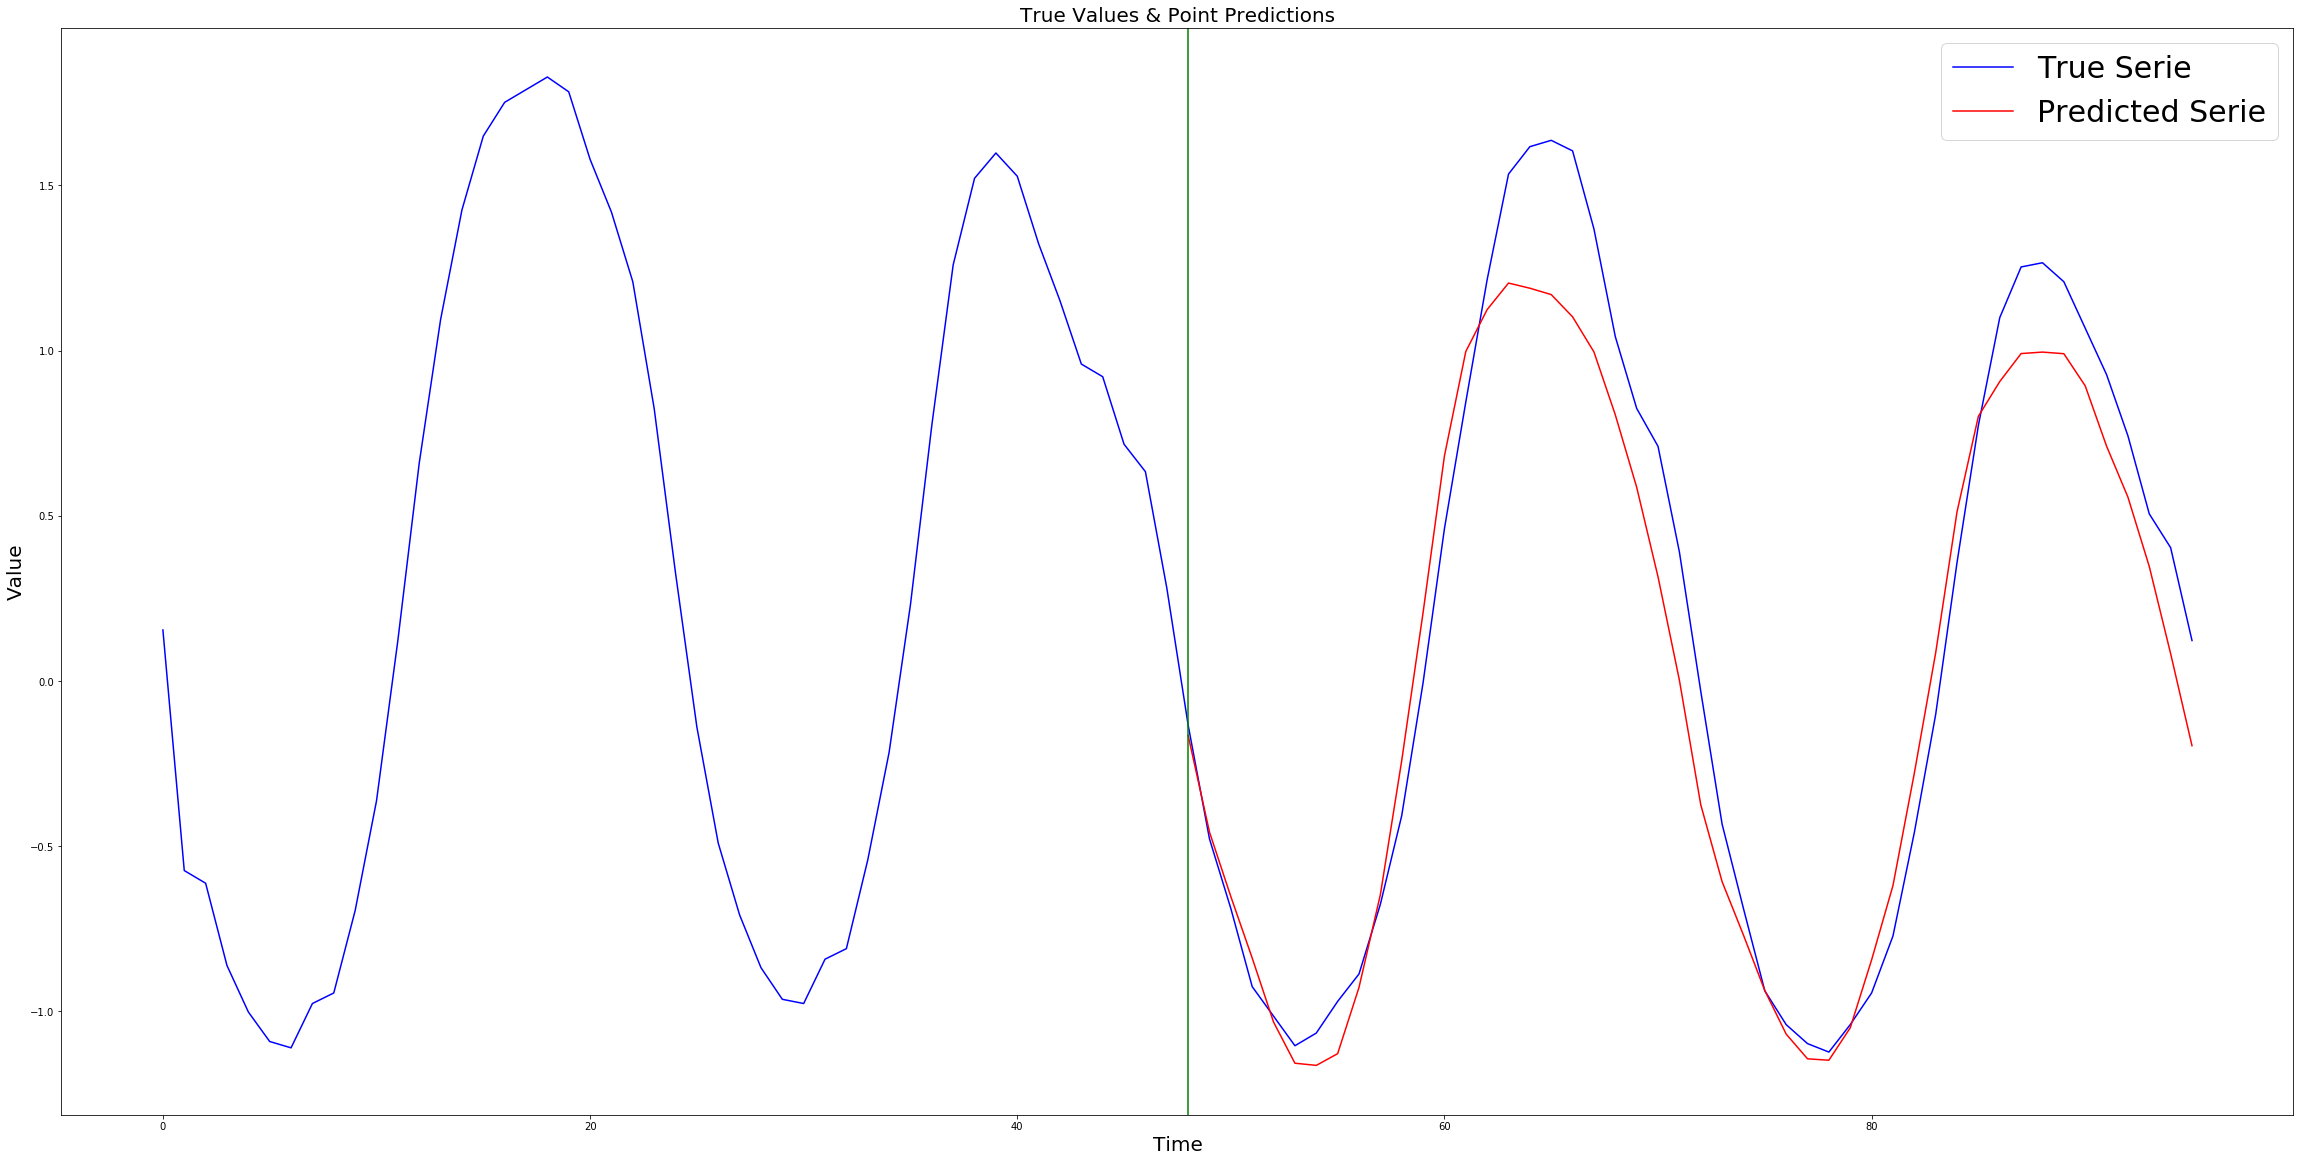

In [8]:
IDX = 0
x = test_x[:BATCH_SIZE,:]
y = test_y[:BATCH_SIZE,:]
#============ Predict Test
predictedY = model.predict(x.reshape(BATCH_SIZE, LOOKBACK, -1 ))
#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(x[:,:,0], y[:,:48], predictedY[:,:48], serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [10]:
MODEL_NUMBER = 3
MODEL_BASE_DIR = '../models/with_kl_pi_params_diff/3-LSTM'
hyperparameters, training_error, test_error, validation_error = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                                                       '../Dataset/Train/Hourly-train.csv', 
                                                                       '../Dataset/Test/Hourly-test.csv', mase)
print(f'Hyperparameters : {hyperparameters}')
print(f'Training Error For Model ({MODEL_NUMBER}) : {training_error}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {test_error}')
print(f'Validation Error For Model ({MODEL_NUMBER}) : {validation_error}')

Loaded model from disk
Hyperparameters : {'epochs': 50, 'learning_rate': 0.001, 'batch_size': 50, 'hidden_layer_size': 120, 'lookback': 48, 'loss': 'mae', 'dropout_ratio': 0.5, 'features_number': 3, 'output_size': 144, 'pi_params': {'max_coff': 1.0, 'min_coff': 0.3, 'step': 0.3}}
Training Error For Model (3) : 1.0
Test Error For Model (3) : 1.105
Validation Error For Model (3) : 1.091


# Evaluate Model PIs

In [11]:
model = M4Model()
model.load('../models/with_kl_pi_params_diff/3-LSTM/3')

y = test_y[:,:HORIZON]
x = test_x[:,:,0]
print(x.shape)

predictedY = model.predict(test_x)
lower_bound = predictedY[:,:HORIZON] - tf.abs(predictedY[:,-HORIZON:])
upper_bound = predictedY[:,:HORIZON] + tf.abs(predictedY[:,-HORIZON:])

print(acd(y, lower_bound.numpy(), upper_bound.numpy()))
print(msis(x, y, lower_bound.numpy(), upper_bound.numpy()))

Loaded model from disk
(394, 48)
0.1364424703891709
15.413993848850447


In [12]:
y = test_y[:,:HORIZON]
lower, upper = naive_pi(y)
print(acd( y[:,:-1], lower, upper))
print(msis(test_x[:,:,0],  y[:,:-1], lower, upper))

0.0462738956690788
15.255543340076647


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    
true_series_time_axes = np.arange(0, 48)
axs.plot(true_series_time_axes, test_y[0,:48], color='r')
axs.plot(true_series_time_axes, test_y[0,:48] - test_y[0,48:], color='y')
axs.plot(true_series_time_axes, test_y[0,:48] + test_y[0,48:], color='c')

print(test_y[0,:48].min() )
print( (test_y[0,:48] - test_y[0,48:]).min())
print( (test_y[0,:48] + test_y[0,48:]).min())

In [ ]:
lower_bounds = test_y[:,:48] - test_y[:,-48:]
upper_bounds = test_y[:,:48] + test_y[:,-48:]

for y, lower, upper in zip(test_y, lower_bounds, upper_bounds):
    fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    true_series_time_axes = np.arange(0, 48)
    axs.plot(true_series_time_axes, y[:48], color='b')
    axs.plot(true_series_time_axes, lower, color='y')
    axs.plot(true_series_time_axes, upper, color='c')
    plt.show()